In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [3]:
# Define the stock symbol and data period
ticker_symbol = "QQQ"
df = yf.download(ticker_symbol, period="5y")  # Get the past 5 years of data


# Display the first few rows of the dataframe
print(df.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker             QQQ         QQQ         QQQ         QQQ       QQQ
Date                                                                
2020-03-27  179.823975  184.879999  179.202889  181.405794  58845000
2020-03-30  186.364777  186.801490  180.833227  181.531951  49356900
2020-03-31  184.773224  189.479901  183.608690  186.054222  62659300
2020-04-01  176.922333  182.114234  175.515186  179.309641  53715400
2020-04-02  180.512985  184.482128  175.621935  175.883960  56465300


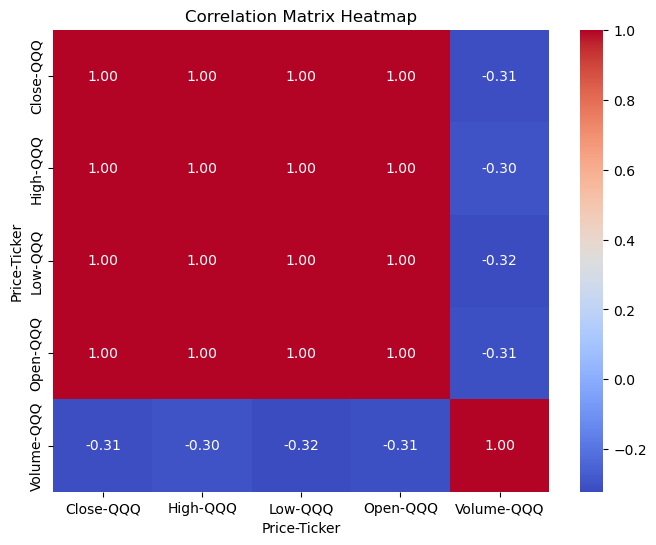

In [29]:
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [4]:
# Subset the data to only use close
clean_df = df[['Close']]
clean_df.head()

Price,Close
Ticker,QQQ
Date,
2020-03-27,179.823975
2020-03-30,186.364777
2020-03-31,184.773224
2020-04-01,176.922333
2020-04-02,180.512985


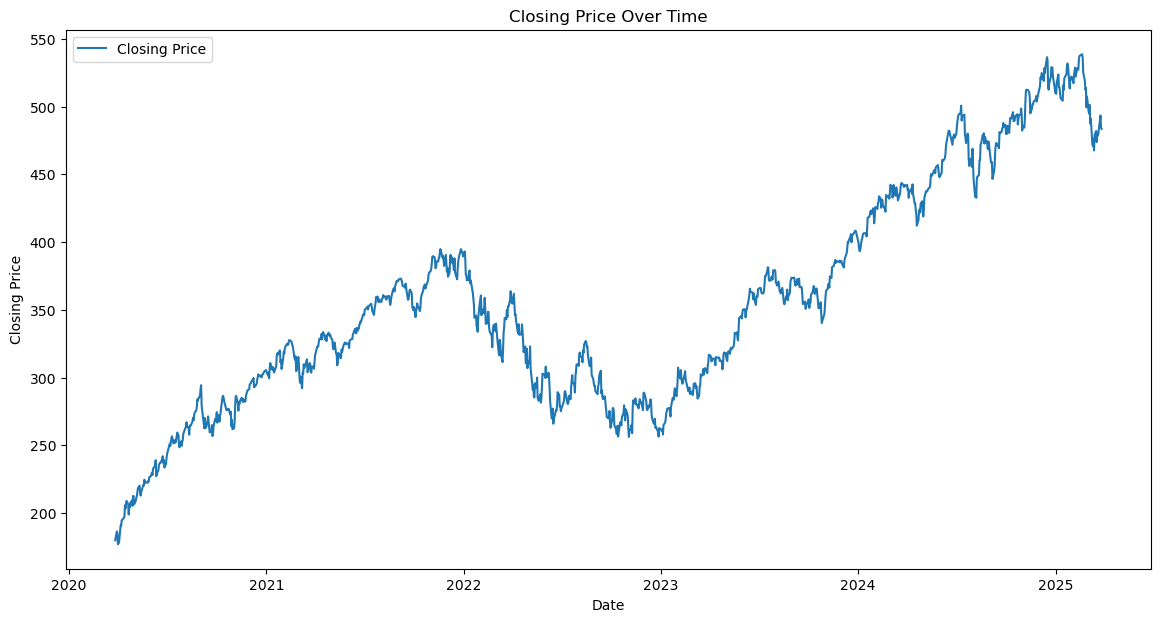

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price Over Time')
plt.legend()

In [6]:

clean_df = clean_df.copy()

# create lag features for past 3 days' closing prices
clean_df.loc[:, 'Close_lag1'] = clean_df['Close'].shift(1)
clean_df.loc[:, 'Close_lag2'] = clean_df['Close'].shift(2)
clean_df.loc[:, 'Close_lag3'] = clean_df['Close'].shift(3)


clean_df = clean_df.dropna()

# reorder columns
clean_df = clean_df[['Close_lag3', 'Close_lag2', 'Close_lag1','Close']]

# select features and label variable
features = ['Close_lag1', 'Close_lag2', 'Close_lag3']
target = 'Close'

# prepare X (features) and y (label)
X = clean_df[features].values
y = clean_df[target].values

print(clean_df.head())

Price       Close_lag3  Close_lag2  Close_lag1       Close
Ticker                                                 QQQ
Date                                                      
2020-04-01  179.823975  186.364777  184.773224  176.922333
2020-04-02  186.364777  184.773224  176.922333  180.512985
2020-04-03  184.773224  176.922333  180.512985  177.950989
2020-04-06  176.922333  180.512985  177.950989  190.673553
2020-04-07  180.512985  177.950989  190.673553  190.595917


In [7]:
df_as_np = clean_df.to_numpy()
dates = np.array(clean_df.index)

middle_matrix = df_as_np[:, 0:-1]
X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)).astype(str)
X = X.astype(np.float32)

Y = df_as_np[:, -1].astype(str)
y = Y.astype(np.float32)

#double-check shapes
dates.shape, X.shape, y.shape

((1254,), (1254, 3, 1), (1254,))

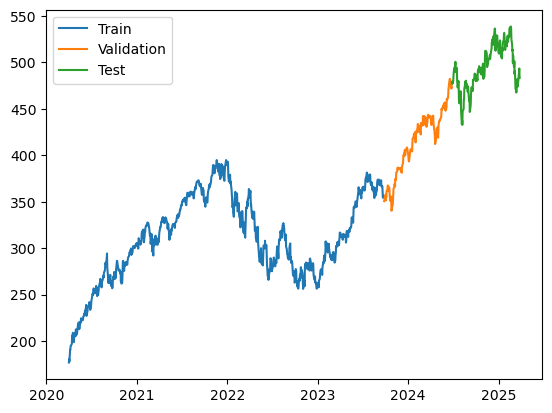

In [8]:
# split into training data and remaining val/test data
dates_train, dates_rem, X_train, X_rem, y_train, y_rem = train_test_split(
    dates, X, y, train_size=0.7, random_state=42, shuffle=False)

# split second half into validation and test
dates_val, dates_test, X_val, X_test, y_val, y_test = train_test_split(
    dates_rem, X_rem, y_rem, test_size=0.5, random_state=42, shuffle=False)

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [9]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)
print(model.summary)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 97777.4453 - mean_absolute_error: 309.4011 - val_loss: 171051.2500 - val_mean_absolute_error: 412.1147
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97813.1016 - mean_absolute_error: 309.5435 - val_loss: 166783.6562 - val_mean_absolute_error: 406.9006
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94882.8203 - mean_absolute_error: 304.6029 - val_loss: 155298.0469 - val_mean_absolute_error: 392.5326
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82682.2500 - mean_absolute_error: 283.8602 - val_loss: 131905.9062 - val_mean_absolute_error: 361.5139
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 63594.9414 - mean_absolute_error: 247.9018 - val_loss: 97361.0859 - val_mean_absolute_error: 310.0780
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37604.0234 - mean_absolute_error: 188.0186 - val_loss: 55928.3672 - val_mean_absolute_error: 233.9142
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


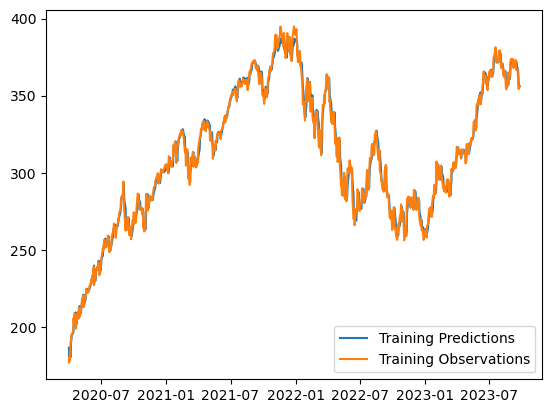

In [10]:
train_predictions = model.predict(X_train)

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


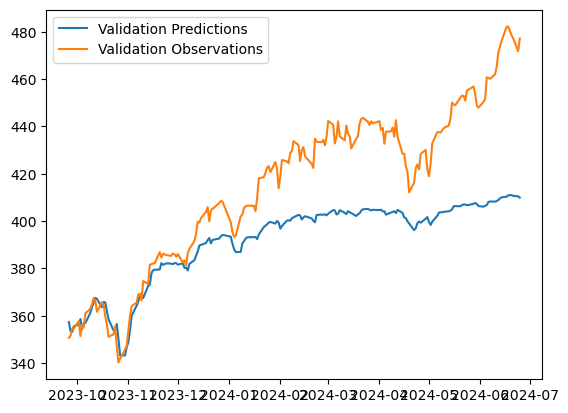

In [11]:
val_predictions = model.predict(X_val)

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


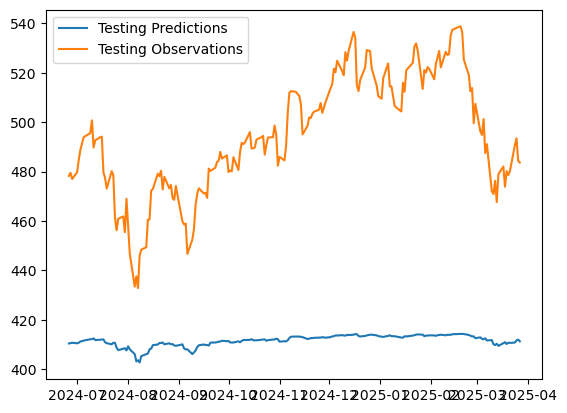

In [12]:
test_predictions = model.predict(X_test)

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

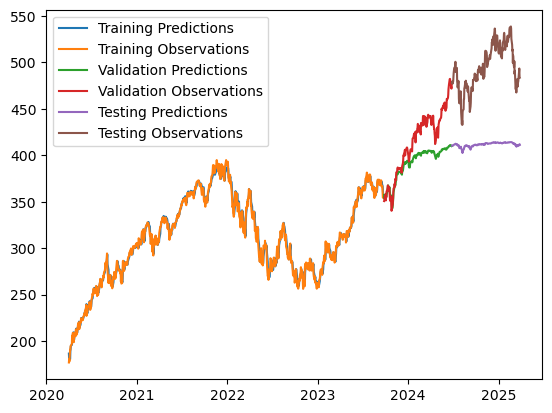

In [13]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])